In [1]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kr_helper_funcs as kru

SEED =  kru.seed_all()
kru.setupSciLabModules()

# sns.set(context='notebook', style='whitegrid', font_scale=1.
# kru.setupSciLabModules()2)
%matplotlib inline

In [2]:
data_file = os.path.join(os.getcwd(), "data", "titanic3.csv")
print(data_file)
assert os.path.exists(data_file), f"FATAL: {data_file} path does not exist!"

c:\Dev\Code\git-projects\dl-keras\data\titanic3.csv


In [3]:
# read in the CSV
data = pd.read_csv(data_file) #, index_col=0)

In [ ]:
data.replace("?", np.nan, inplace=True)
data = data.astype({"age": np.float64, "fare": np.float64})

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [5]:
data.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

<AxesSubplot: xlabel='survived', ylabel='fare'>

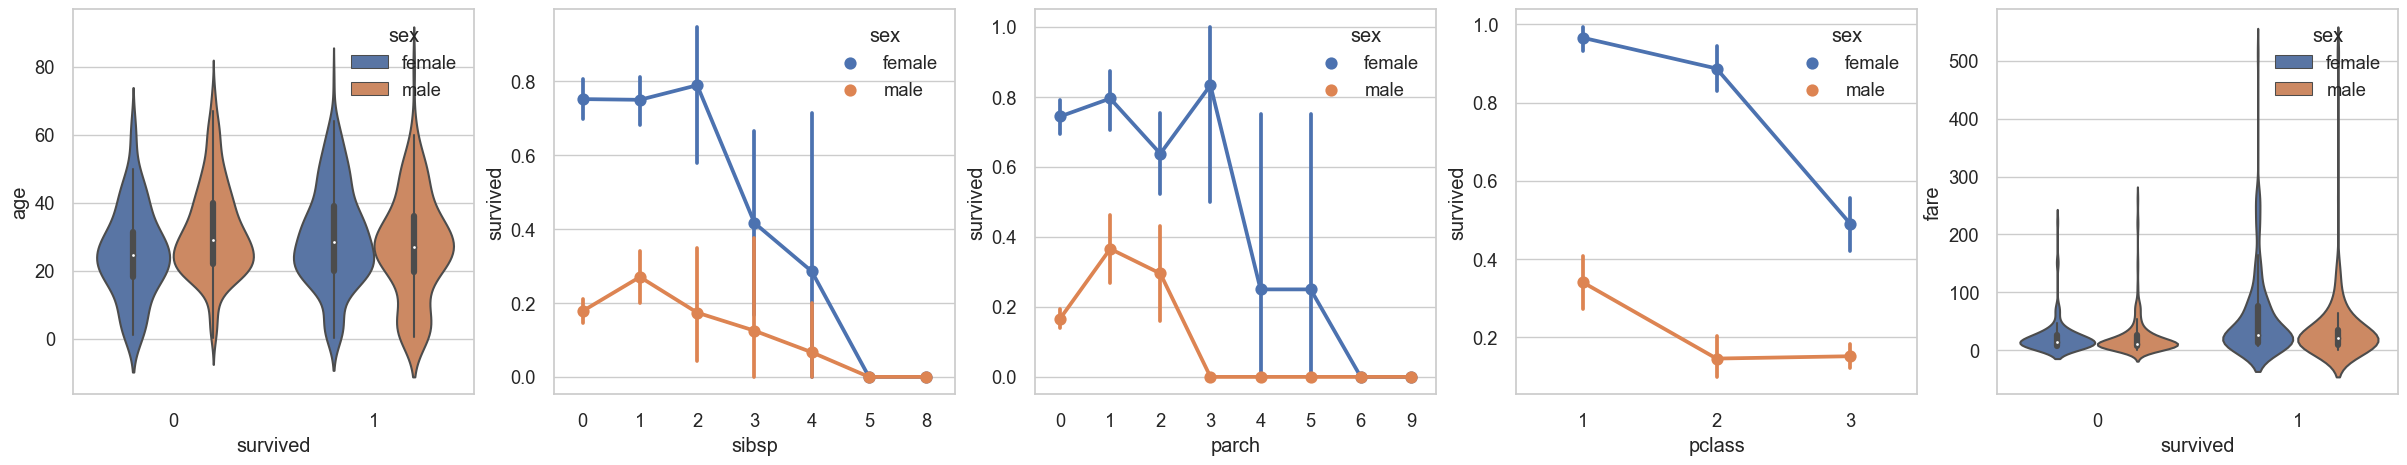

In [6]:
# let's look at some plots
fig, axs = plt.subplots(ncols=5, figsize=(30, 5))
sns.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0])
sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])

In [7]:
data.replace({'male':1, "female":0}, inplace=True)

In [8]:
data.corr().abs()[['survived']]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN


The above table shows that `gender` has a high corelation with `survived`, whereas `sibsp` (siblings or spouse) and `parch` (parents or children) do not. It seems logical that people with a relative (either parent, sibling or child) may have had a higher chance of survival. Let's hypothesize that this is the case & analyze if our hypothesis holds.
First let's add a column `relatives` which is set to 1 if either `sibsp` or `parch` > 0

In [9]:
data['relatives'] = data.apply(lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)
data.corr().abs()['survived']

pclass       0.312469
survived     1.000000
sex          0.528693
age          0.055512
sibsp        0.027825
parch        0.082660
fare         0.244265
body              NaN
relatives    0.201719
Name: survived, dtype: float64

So yeah! It appears that having a relative on board (and not the actual count of relatives) does indeed impact the chance of survivability, since the `corr()` value for relatives is 0.2 (>> than the individual values for `sibsp` or `parch`)

In [10]:
# use just a subset of data, dropping all nans
data2 = data[['sex', 'pclass', 'age', 'relatives', 'fare', 'survived']].dropna()

### Prepare data for training
In this section we'll split data in to train/test sets

In [11]:
X = data2[['sex', 'pclass', 'age', 'relatives', 'fare']]
y = data2['survived']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print(f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - " +
      f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape}")

X_train.shape: (836, 5) - y_train.shape: (836,) - X_test.shape: (209, 5) - y_test.shape: (209,)


In [13]:
# normalize the data
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### Applying various models
Next let's apply various classification models available in `scikit-learn`

In [14]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)


GaussianNB()

In [15]:
from sklearn import metrics
predict_test = model.predict(X_test)
print(metrics.accuracy_score(y_test, predict_test))


0.7368421052631579


In [16]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,0.810811,0.725806,0.765957,124.000000
1,0.653061,0.752941,0.699454,85.000000
accuracy,0.736842,0.736842,0.736842,0.736842
macro avg,0.731936,0.739374,0.732705,209.000000
weighted avg,0.746654,0.736842,0.738910,209.000000


### Using a Keras Neural Network

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [18]:
def build_model():
    model = Sequential([
        Dense(16, kernel_initializer='uniform', activation='relu', input_dim=5),
        # Dense(5, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [19]:
model = build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                96        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
hist = model.fit(X_train, y_train, validation_split=0.20, batch_size=16, epochs=50)

Epoch 1/50
42/42 [==============================] - 5s 11ms/step - loss: 0.6874 - accuracy: 0.6003 - val_loss: 0.6782 - val_accuracy: 0.6190
Epoch 2/50
42/42 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.6856 - val_loss: 0.6393 - val_accuracy: 0.7440
Epoch 3/50
42/42 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.7590 - val_loss: 0.5864 - val_accuracy: 0.7738
Epoch 4/50
42/42 [==============================] - 0s 3ms/step - loss: 0.5746 - accuracy: 0.7665 - val_loss: 0.5421 - val_accuracy: 0.7738
Epoch 5/50
42/42 [==============================] - 0s 3ms/step - loss: 0.5392 - accuracy: 0.7665 - val_loss: 0.5100 - val_accuracy: 0.7857
Epoch 6/50
42/42 [==============================] - 0s 4ms/step - loss: 0.5135 - accuracy: 0.7740 - val_loss: 0.4898 - val_accuracy: 0.7857
Epoch 7/50
42/42 [==============================] - 0s 4ms/step - loss: 0.4954 - accuracy: 0.7799 - val_loss: 0.4796 - val_accuracy: 0.7619
Epoch 8/50
42/42 [=

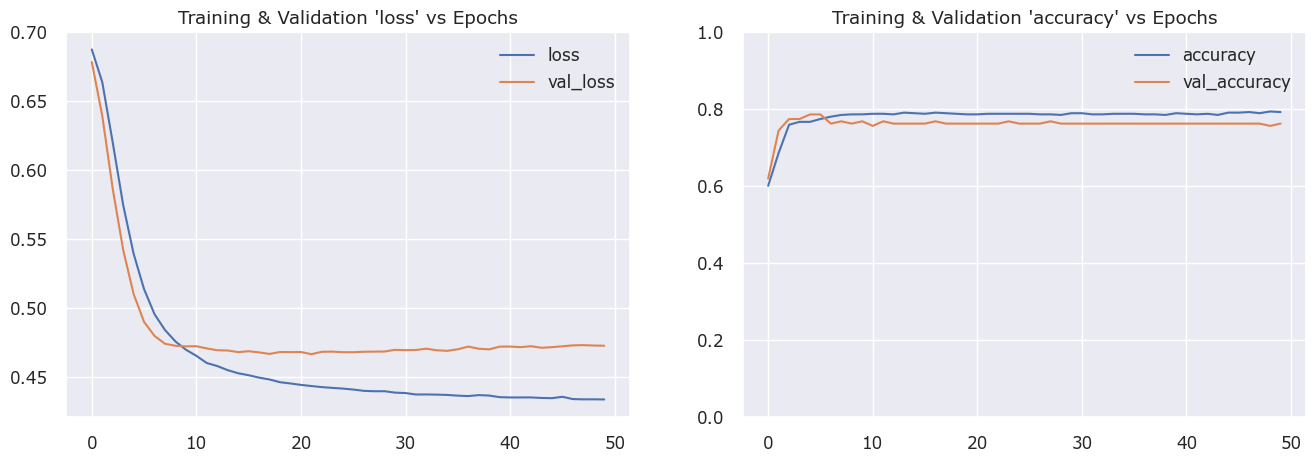

In [22]:
kru.show_plots(hist.history, metric='accuracy')

In [23]:
loss, acc = model.evaluate(X_train, y_train)
print(f"Train -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = model.evaluate(X_test, y_test)
print(f"Test -> loss: {loss:.3f} - acc: {acc:.3f}")

27/27 [==============================] - 0s 2ms/step - loss: 0.4404 - accuracy: 0.7847
Train -> loss: 0.440 - acc: 0.785
7/7 [==============================] - 0s 2ms/step - loss: 0.4593 - accuracy: 0.7799
Test -> loss: 0.459 - acc: 0.780


In [24]:
y_pred = np.round(model.predict(X_test)).flatten()
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred):.3f}")

7/7 [==============================] - 0s 2ms/step
Accuracy: 0.780


In [25]:
from sklearn.metrics import classification_report

y_pred = np.round(model.predict(X_test)).flatten()

report = classification_report(y_test, y_pred, output_dict=True)
df2 = pd.DataFrame(report).transpose()
df2

7/7 [==============================] - 0s 2ms/step


,precision,recall,f1-score,support
0,0.795455,0.846774,0.820313,124.000000
1,0.753247,0.682353,0.716049,85.000000
accuracy,0.779904,0.779904,0.779904,0.779904
macro avg,0.774351,0.764564,0.768181,209.000000
weighted avg,0.778289,0.779904,0.777909,209.000000


In [26]:
save_path = os.path.join(os.getcwd(), "model_states", "kr_titanic.dat")
kru.save_model(model, save_path)

Keras model saved to c:\Dev\Code\git-projects\dl-keras\model_states\kr_titanic.dat
